### Import Libraries


In [112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')




### Load and Explore Data

In [113]:
df = pd.read_csv("C:\\Users\\Hp\\Downloads\\bank_transactions_data_2.csv")
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['PreviousTransactionDate'] = pd.to_datetime(df['PreviousTransactionDate'])
df['TransactionHour'] = df['TransactionDate'].dt.hour




In [114]:
df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate,TransactionHour
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08,16
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35,16
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04,18
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06,16
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39,17


### Checking for null values

In [115]:
df.isnull().sum()

TransactionID              0
AccountID                  0
TransactionAmount          0
TransactionDate            0
TransactionType            0
Location                   0
DeviceID                   0
IP Address                 0
MerchantID                 0
Channel                    0
CustomerAge                0
CustomerOccupation         0
TransactionDuration        0
LoginAttempts              0
AccountBalance             0
PreviousTransactionDate    0
TransactionHour            0
dtype: int64

### Labeling based on rules

In [116]:
df['is_fraud'] = (
    (df['TransactionAmount'] > 1000) |
    (df['LoginAttempts'] > 3) |
    (df['TransactionHour'].isin([0,1,2,3,4,5,23])) |
    (df['TransactionDuration'] > 250)
).astype(int)

### Visualize

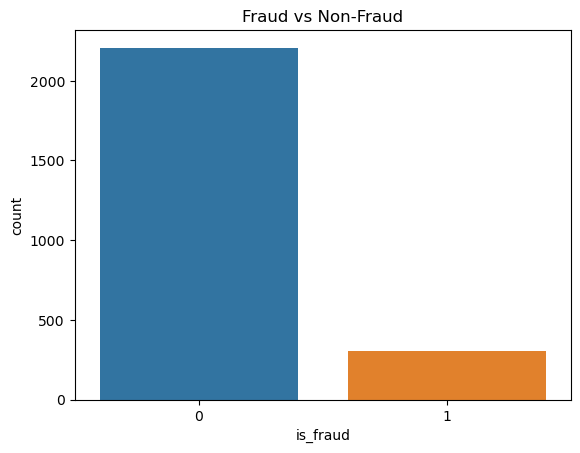

In [117]:
sns.countplot(x='is_fraud', data=df)
plt.title("Fraud vs Non-Fraud")
plt.show()

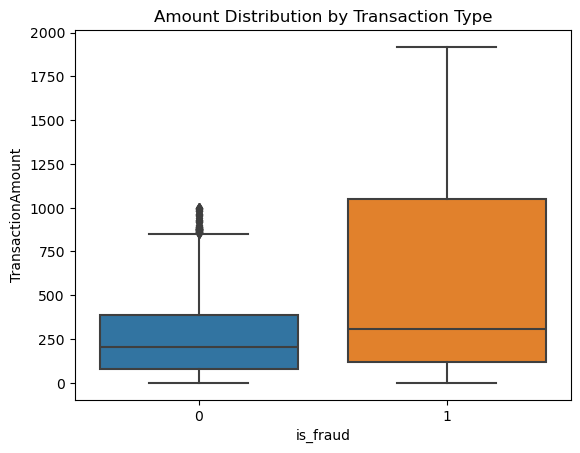

In [118]:
sns.boxplot(x='is_fraud', y='TransactionAmount', data=df)
plt.title("Amount Distribution by Transaction Type")
plt.show()


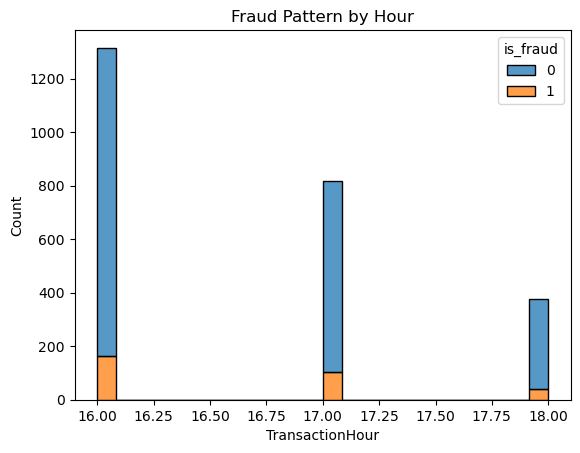

In [119]:

sns.histplot(data=df, x='TransactionHour', hue='is_fraud', multiple='stack', bins=24)
plt.title("Fraud Pattern by Hour")
plt.show()



### Data Preprocessing

In [120]:
# One-hot encode categorical
X = pd.get_dummies(df.drop(columns=['TransactionID','AccountID','TransactionDate','PreviousTransactionDate','IP Address','is_fraud']), drop_first=True)
y = df['is_fraud']

### Machine Learning Models

In [121]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [123]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [124]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [125]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


In [126]:
# List of models to evaluate
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "XGBoost": XGBClassifier( use_label_encoder=False,eval_metric='logloss'),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

### Evaluation

In [127]:
for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    print(f"Model: {name}")
    print("Sample Predictions:", y_pred[:10])
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("AUC ROC:", roc_auc_score(y_test, y_prob))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("=" * 60)


Model: Logistic Regression
Sample Predictions: [0 1 0 0 0 0 1 0 0 0]
F1 Score: 0.4795321637426901
Precision: 0.5125
Recall: 0.45054945054945056
AUC ROC: 0.898629274194885
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93       663
           1       0.51      0.45      0.48        91

    accuracy                           0.88       754
   macro avg       0.72      0.70      0.71       754
weighted avg       0.88      0.88      0.88       754

Model: Decision Tree
Sample Predictions: [0 1 0 0 0 0 1 0 0 0]
F1 Score: 0.8625592417061612
Precision: 0.7583333333333333
Recall: 1.0
AUC ROC: 0.9781297134238311
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       663
           1       0.76      1.00      0.86        91

    accuracy                           0.96       754
   macro avg       0.88      0.98      0.92       754
weighted avg       0

### Hyperparameter Tuning

In [128]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 150],
    'learning_rate': [0.05, 0.1, 0.2]
}

grid = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', use_label_encoder=False ),
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)

grid.fit(X_train_smote, y_train_smote)

print("Best Params:", grid.best_params_)
best_model = grid.best_estimator_


Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}


### Deep Learning Models

In [129]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_smote.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fit the model
history = model.fit(
    X_train_smote, y_train_smote,                   # Use SMOTE'd data
    epochs=10,
    validation_split=0.2,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)],  # Optional: restore best model
    verbose=1
)


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6434 - loss: 0.6089 - val_accuracy: 0.9159 - val_loss: 0.2785
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9346 - loss: 0.1936 - val_accuracy: 0.9887 - val_loss: 0.0898
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 0.0581 - val_accuracy: 1.0000 - val_loss: 0.0283
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9994 - loss: 0.0201 - val_accuracy: 1.0000 - val_loss: 0.0167
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0095 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 1.0000 - val_loss: 0.0043
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 0.0025
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss:

In [130]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_prob = model.predict(X_test_scaled).ravel()
y_pred_class = (y_pred_prob > 0.5).astype(int)

print("AUC ROC:", roc_auc_score(y_test, y_pred_prob))
print(classification_report(y_test, y_pred_class))


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
AUC ROC: 0.7743026204564666
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       663
           1       0.50      0.25      0.34        91

    accuracy                           0.88       754
   macro avg       0.70      0.61      0.63       754
weighted avg       0.86      0.88      0.86       754



### Summary Table

In [131]:
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, classification_report

# Initialize results list
model_results = []

# Loop for ML models
for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Print 
    print(f"Model: {name}")
    print("Sample Predictions:", y_pred[:10])
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("AUC ROC:", roc_auc_score(y_test, y_prob))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("=" * 60)

    # Append results to summary table
    model_results.append({
        'Model': name,
        'F1 Score': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'AUC ROC': roc_auc_score(y_test, y_prob)
    })

# Deep Learning model (already trained earlier)
y_pred_prob_dl = model.predict(X_test_scaled).ravel()
y_pred_class_dl = (y_pred_prob_dl > 0.5).astype(int)

# Print DL results
print("Model: Deep Learning (Keras)")
print("Sample Predictions:", y_pred_class_dl[:10])
print("F1 Score:", f1_score(y_test, y_pred_class_dl))
print("Precision:", precision_score(y_test, y_pred_class_dl))
print("Recall:", recall_score(y_test, y_pred_class_dl))
print("AUC ROC:", roc_auc_score(y_test, y_pred_prob_dl))
print("Classification Report:\n", classification_report(y_test, y_pred_class_dl))
print("=" * 60)

# Append DL to summary
model_results.append({
    'Model': 'Deep Learning (Keras)',
    'F1 Score': f1_score(y_test, y_pred_class_dl),
    'Precision': precision_score(y_test, y_pred_class_dl),
    'Recall': recall_score(y_test, y_pred_class_dl),
    'AUC ROC': roc_auc_score(y_test, y_pred_prob_dl)
})

# Create and display summary table
results_df = pd.DataFrame(model_results)
results_df = results_df.sort_values(by='F1 Score', ascending=False)
print("\n Summary Table:")
print(results_df)


Model: Logistic Regression
Sample Predictions: [0 1 0 0 0 0 1 0 0 0]
F1 Score: 0.4795321637426901
Precision: 0.5125
Recall: 0.45054945054945056
AUC ROC: 0.898629274194885
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.93       663
           1       0.51      0.45      0.48        91

    accuracy                           0.88       754
   macro avg       0.72      0.70      0.71       754
weighted avg       0.88      0.88      0.88       754

Model: Decision Tree
Sample Predictions: [0 1 0 0 0 0 1 0 0 0]
F1 Score: 0.8666666666666666
Precision: 0.7647058823529411
Recall: 1.0
AUC ROC: 0.9788838612368025
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       663
           1       0.76      1.00      0.87        91

    accuracy                           0.96       754
   macro avg       0.88      0.98      0.92       754
weighted avg       0

### From summary table we observed that Xgboost is the suitable model so we will deploy it

### Finish Model

In [132]:
import joblib

joblib.dump(best_model, 'xgb_best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(X_train.columns.tolist(), 'xgb_model_features.pkl')



['xgb_model_features.pkl']